In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [3]:
df = pd.read_csv("dataset.csv")
df.shape

(31059, 35)

In [4]:
df.head()

seas_id  season  player_id        player  birth_year pos   age  experience  \
0    30458    2023       5025    A.J. Green         NaN  SG  23.0           1   
1    30459    2023       5026   A.J. Lawson         NaN  SG  22.0           1   
2    30460    2023       5026   A.J. Lawson         NaN  SG  22.0           1   
3    30461    2023       5026   A.J. Lawson         NaN  SG  22.0           1   
4    30462    2023       4219  Aaron Gordon         NaN  PF  27.0           9   

    lg   tm  ...  ft_percent    orb    drb    trb  ast   stl   blk   tov  pf  \
0  NBA  MIL  ...       1.000    4.0   24.0   28.0   12   5.0   0.0   7.0  24   
1  NBA  TOT  ...       0.333    2.0    8.0   10.0    1   1.0   0.0   1.0   8   
2  NBA  MIN  ...         NaN    0.0    1.0    1.0    0   0.0   0.0   0.0   1   
3  NBA  DAL  ...       0.333    2.0    7.0    9.0    1   1.0   0.0   1.0   7   
4  NBA  DEN  ...       0.623  118.0  218.0  336.0  140  40.0  39.0  79.0  91   

   pts  
0  121  
1   34  
2    2  
3   32  
4  848  

[5 rows x 35 columns]

In [5]:
df = df[(df['pos'] == 'SG') | (df['pos'] == 'PF') | (df['pos'] == 'PG') | (df['pos'] == 'SF') | (df['pos'] == 'C')]
df.shape

(29666, 35)

In [6]:
cols = ['player_id', 'player', 'pos', 'g', 'mp', 'fg', 'fga', 'x3p', 'x2p', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
df2 = df[cols]
df2 = df2.groupby(['player_id', 'pos']).sum().reset_index()
df2 = df2.dropna()
df2.shape

(6128, 19)

In [7]:
df2.head()

player_id pos    g      mp    fg   fga  x3p   x2p    ft   fta  orb  drb  \
0          7   C   71     0.0   134   483  0.0   134   150   203  0.0  0.0   
1         12  SG  321   139.0  1481  4207  0.0  1481  1085  1343  0.0  0.0   
2         16   C   54     0.0    93   356  0.0    93    52    91  0.0  0.0   
3         27  SF  362  1083.0  1247  4171  0.0  1247   762  1071  0.0  0.0   
4         36   C  477     0.0  1432  4601  0.0  1432  1377  2157  0.0  0.0   

      trb  ast  stl  blk  tov    pf   pts  
0     0.0   44  0.0  0.0  0.0   169   418  
1   374.0  756  0.0  0.0  0.0   729  4047  
2     0.0   22  0.0  0.0  0.0   113   238  
3   571.0  588  0.0  0.0  0.0  1159  3256  
4  1078.0  741  0.0  0.0  0.0  1331  4241

In [8]:
df2 = df2[df2['mp'] > 0]
df2.shape

(6094, 19)

In [9]:
# Split Train And Test Data
X = df2.drop(['player_id', 'pos'], axis=1)
y = df2['pos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
pipelines = [
    {
        'model': 'Logistic Regression',
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression())
        ]),
        'params': {
            'lr__penalty': ['l2'],
            'lr__C': [0.1, 1, 10, 100]
        }
    },
    {
        'model': 'Decision Tree',
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('dt', DecisionTreeClassifier(random_state=42))
        ]),
        'params': {
            'dt__max_depth': [None, 10, 20],
            'dt__min_samples_split': [2, 5, 10]
        }
    },
    {
        'model': 'Random Forest',
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'rf__n_estimators': [100, 500, 1000],
            'rf__max_depth': [None, 10, 20],
            'rf__min_samples_split': [2, 5, 10]
        }
    },
    {
        'model': 'K-nearest Neighbor',
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ]),
        'params': {
            'knn__n_neighbors': [3, 5, 7],
            'knn__weights': ['uniform', 'distance']
        }
    },
    {
        'model': 'Neural Networks',
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('nn', MLPClassifier(random_state=42, max_iter=1000))
        ]),
        'params': {
            'nn__hidden_layer_sizes': [(64,), (32, 32), (64, 32)],
            'nn__activation': ['relu', 'tanh'],
            'nn__alpha': [0.0001, 0.001, 0.01]
        }
    }
]

best_model = None
best_model_name = None
best_model_hyperparams = None
best_acc   = 0
for item in pipelines:
    gs = GridSearchCV(item['pipeline'], item['params'], cv=5, n_jobs=-1, verbose=1, error_score='raise')
    gs.fit(X_train, y_train)
    model = gs.best_estimator_
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(item['model'], ' test accuracy\t: ', acc)
    print()
    if acc > best_acc:
        best_model = model
        best_model_name = item['model']
        best_model_hyperparams = gs.best_params_
print('---------------------------------------------------------------------')
print('Best model is ', best_model_name)
print('Best hyperparameters for ', best_model_name, ': ', best_model_hyperparams)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\User\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression  test accuracy	:  0.5332239540607056

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Decision Tree  test accuracy	:  0.3945857260049221

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest  test accuracy	:  0.5192780968006563

Fitting 5 folds for each of 6 candidates, totalling 30 fits
K-nearest Neighbor  test accuracy	:  0.46513535684987695

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Neural Networks  test accuracy	:  0.5159967186218212

---------------------------------------------------------------------
Best model is  Neural Networks
Best hyperparameters for  Neural Networks :  {'nn__activation': 'relu', 'nn__alpha': 0.0001, 'nn__hidden_layer_sizes': (32, 32)}


In [11]:
X_train_pred = best_model.predict(X_train)
X_test_pred = best_model.predict(X_test)

<AxesSubplot:>

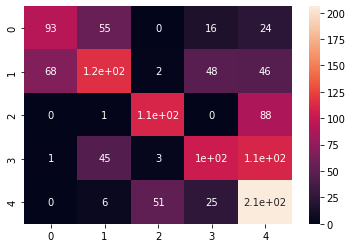

In [12]:
cf_mx = confusion_matrix(y_test, X_test_pred)
sns.heatmap(cf_mx, annot=True)

In [13]:
prec = precision_score(y_train, X_train_pred, average='macro')
rec = recall_score(y_train, X_train_pred, average='macro')
f1 = f1_score(y_train, X_train_pred, average='macro')
# print('Precision\t: {:.2f}'.format(rf_prec))
# print('orest Recall\t: {:.2f}'.format(rf_rec))df2
# print('Random Forest F1-score\t: {:.2f}'.format(rf_f1))

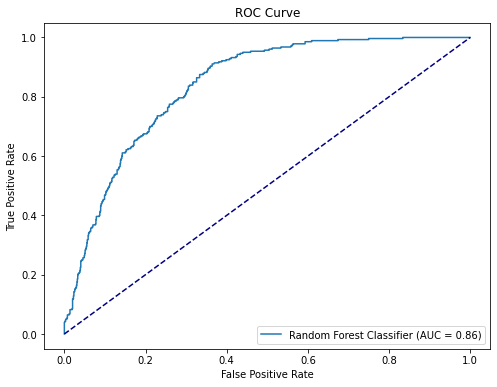

In [14]:
rf_probs = model.predict_proba(X_test)
rf_auc = roc_auc_score(y_test, rf_probs, multi_class='ovr')
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs[:, 1], pos_label=model.classes_[1])
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest Classifier (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
# joblib.dump(best_model, 'model.joblib')

In [16]:
def pgp_score(r):
    if r['tov'] == 0:
        pgp = 0
    else:
        pgp = (r['ast'] + r['stl'])/r['tov']
    return pgp

def sgp_score(r):
    if (r['fga'] + r['fta']) == 0:
        sgp = 0
    else:
        sgp = (r['pts'] + r['x3p'] + r['x2p'])/(r['fga'] + r['fta'])
    return sgp

def pfp_score(r):
    if (r['fga'] + r['fta']) == 0:
        pfp = 0
    else:
        pfp = (r['pts'] + r['trb'])/(r['fga'] + r['fta'])
    return pfp

def sfp_score(r):
    if r['mp'] == 0:
        sfp = 0
    else:
        sfp = (r['pts'] + r['trb'] + r['ast'] + r['stl'] + r['blk'])/(r['mp'] * 5)
    return sfp

def ctp_score(r):
    if r['mp'] == 0:
        ctp = 0
    else:
        ctp = (r['pts'] + r['trb'] + r['blk'])/(r['mp'] * 5)
    return ctp

In [17]:
df3 = df[df['season'] == 2023]
cols = ['player_id', 'pos', 'age', 'g', 'mp', 'fg', 'fga', 'x3p', 'x2p', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
df3 = df3[cols]
df3 = df3.groupby(['player_id', 'pos', 'age']).sum().reset_index()
df3.shape

(510, 20)

In [18]:
df3['pred_pos'] = None
stat_cols = ['g', 'mp', 'fg', 'fga', 'x3p', 'x2p', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
for i, r in df3.iterrows():
    values = []
    for col in stat_cols:
        values.append(df3.iloc[i][col])
    prediction = model.predict([values])
    df3.at[i, 'pred_pos'] = prediction[0]
df3 = df3[~df3['pos'].isna()]
df3 = df3[~df3['pred_pos'].isna()]
df3.shape

(510, 21)

In [19]:
df3.head()

player_id pos   age   g      mp   fg   fga   x3p  x2p   ft  ...   orb  \
0       3463  PF  38.0  45  1632.0  517  1018  97.0  420  218  ...  51.0   
1       3491   C  42.0   6    46.0    1    12   0.0    1    1  ...   4.0   
2       3500  SF  39.0   3    42.0    3     4   1.0    2    0  ...   1.0   
3       3585  PG  37.0  39  1247.0  185   434  61.0  124  102  ...  15.0   
4       3685  PG  36.0  44  1464.0  169   427  90.0   79  100  ...  38.0   

     drb    trb  ast   stl   blk    tov   pf   pts  pred_pos  
0  328.0  379.0  315  43.0  25.0  142.0   73  1349        PF  
1    4.0    8.0    0   1.0   1.0    0.0    8     3        SG  
2    6.0    7.0    5   1.0   1.0    5.0    5     7        SG  
3  150.0  165.0  353  62.0  18.0   81.0   84   533        PG  
4  152.0  190.0  232  49.0  17.0   87.0  121   528        PG  

[5 rows x 21 columns]

In [20]:
df3_cols = cols
df3_cols.append('pred_pos')

def df_pos(pos):
    new_df = pd.DataFrame(columns = df3_cols)
    for i, r in df3.iterrows():
        print(new_df)
        if r['pos'] == pos or r['pred_pos'] == pos:
            new_df.loc[len(new_df.index)] = r 
            # new_df = new_df.append(r, ignore_index=True)
    new_df['score'] = 0
    return new_df

def get_score(pos, r):
    if pos == 'PG':
        score = pgp_score(r)
    elif pos == 'SG':
        score = pgp_score(r)
    elif pos == 'PF':
        score = pgp_score(r)
    elif pos == 'SF':
        score = pgp_score(r)
    else:
        score = ctp_score(r)
    return score

positions = ['PG', 'SG', 'PF', 'SF', 'C']
for pos in positions:
    new_df = df_pos(pos)
    for i, r in new_df.iterrows():
        new_df.at[i, 'score'] = get_score(pos, r)
    new_df = new_df.sort_values(by='score', ascending=False)
    filename = pos + '.csv'
    new_df.to_csv(filename, index=False) 
    print(filename, ' saved')

Empty DataFrame
Columns: [player_id, pos, age, g, mp, fg, fga, x3p, x2p, ft, fta, orb, drb, trb, ast, stl, blk, tov, pf, pts, pred_pos]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [player_id, pos, age, g, mp, fg, fga, x3p, x2p, ft, fta, orb, drb, trb, ast, stl, blk, tov, pf, pts, pred_pos]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [player_id, pos, age, g, mp, fg, fga, x3p, x2p, ft, fta, orb, drb, trb, ast, stl, blk, tov, pf, pts, pred_pos]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [player_id, pos, age, g, mp, fg, fga, x3p, x2p, ft, fta, orb, drb, trb, ast, stl, blk, tov, pf, pts, pred_pos]
Index: []

[0 rows x 21 columns]
  player_id pos   age   g      mp   fg  fga   x3p  x2p   ft  ...   orb    drb  \
0      3585  PG  37.0  39  1247.0  185  434  61.0  124  102  ...  15.0  150.0   

     trb  ast   stl   blk   tov  pf  pts pred_pos  
0  165.0  353  62.0  18.0  81.0  84  533       PG  

[1 rows x 21 columns]
  player_id pos   age   g      mp 

In [21]:
pickle.dump(best_model,open('model.pkl','wb'))